# Getting started with Acoular
> An example with 64 microphone array and three sources, beamforming and deconvolution in frequency domain
- Authors: Ennes Sarradj, Adam Kujawski, Mikolaj Czuchaj


## What is Acoular?

* Python library that can process multichannel data (up to a few hundred channels) from acoustic measurements with a microphone array
* **Website**: www.acoular.org
* **GitHub Repository**: https://github.com/acoular/acoular

## Install Acoular and Matplotlib

Two frequently used options to install Acoular:
- Install via pip: `pip install acoular`
- Install via conda: `conda install -c acoular acoular`

To install matplotlib:
- Install via pip: `pip install matplotlib`
- Install via conda: `conda install matplotlib`


## Import Acoular

To use Acoular, we first have to import Acoular into our notebook. (If you use Acoular version < 24.10, make sure that your Numpy version is < 2.0)

In [2]:
import acoular
print(acoular.__version__)

24.10


## Run Acoular Demo

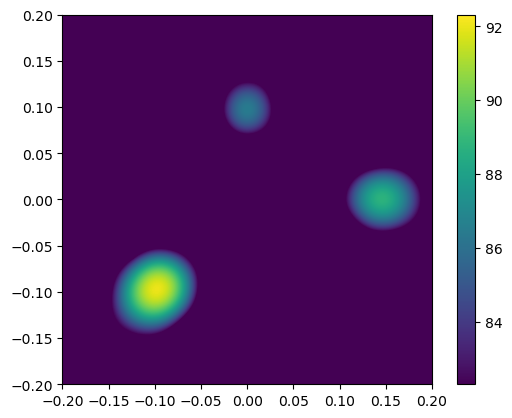

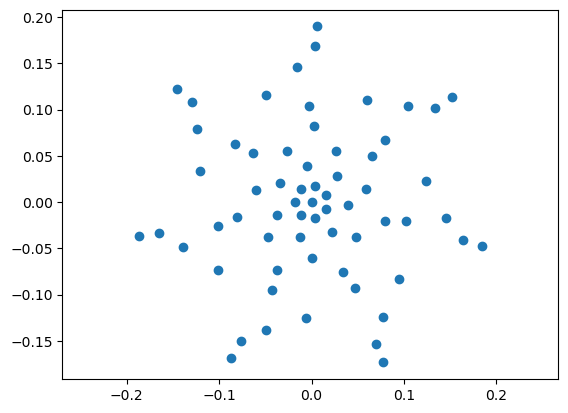

In [3]:
acoular.demo.acoular_demo.run() 

# Analysis of an array measurement in the frequency domain

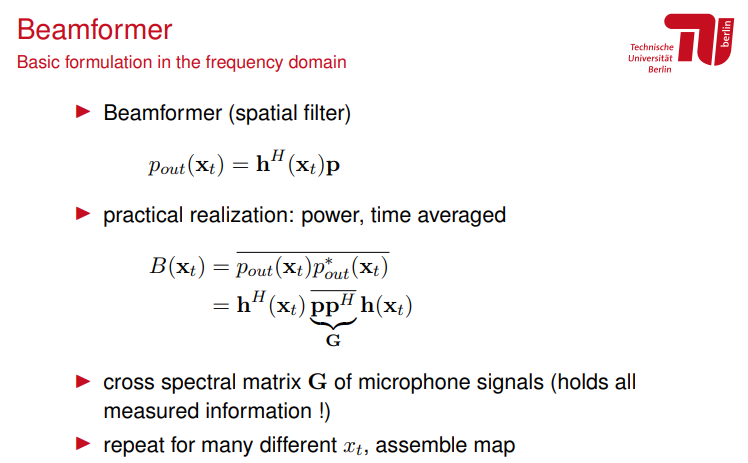

## Load microphone array data

* time histories from 64 microphones stored in the file "three_sources.h5" (see the [`three sources example`](https://www.acoular.org/auto_examples/introductory_examples/example_three_sources.html#sphx-glr-auto-examples-introductory-examples-example-three-sources-py) on how it was created)
* HDF5 format (open all-purpose numerical data container file format)
* contains data from a simulated measurement of a scene with three different sound sources
* stores the time histories of the microphone signals and sampling rate
* to have a look at the file content, use an HDF5 file viewer (e.g. https://www.hdfgroup.org/downloads/hdfview/)

In [4]:
from pathlib import Path
file = Path("three_sources.h5")
assert file.exists(), "File not found, run Acoular demo before!"

ts = acoular.TimeSamples( name=file )

The file is not directly opened using Python commands, but instead we use the [`TimeSamples`](http://acoular.org/api_ref/generated/generated/acoular.sources.TimeSamples.html) class from Acoular. This class manages the data in the file in an intelligent way which even allows to use huge data files that do not fit into the memory.

If we inspect the `ts` object, we see not the data itself, but just the type and the location in memory.

In [8]:
ts.h5f

File(filename=three_sources.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/time_data (EArray(51200, 64)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (256, 64)

We can use this object now to answer some questions about the data:
* How many channels,
* and how many samples do we have? 
* What is the sampling frequency? 

In [11]:
print( ts.numchannels, ts.numsamples, ts.sample_freq )

64 51200 51200.0


## Calculate the cross-spectral matrix


The signal processing can either take place in the time domain or in the frequency domain.
To work in the frequency domain, the time history data must be transformed into power spectra. More specifically, we need the __cross spectral matrix (CSM)__ which contains the pairwise cross spectra of all possible combinations of two channels. The cross spectral matrix is computed using Welch's method. For this, an FFT block size and a window type have to be chosen.

In [20]:
ps = acoular.PowerSpectra( source=ts, block_size=128, window="Hanning")
ps.fftfreq()
#ps.num_blocks

array([    0.,   400.,   800.,  1200.,  1600.,  2000.,  2400.,  2800.,
        3200.,  3600.,  4000.,  4400.,  4800.,  5200.,  5600.,  6000.,
        6400.,  6800.,  7200.,  7600.,  8000.,  8400.,  8800.,  9200.,
        9600., 10000., 10400., 10800., 11200., 11600., 12000., 12400.,
       12800., 13200., 13600., 14000., 14400., 14800., 15200., 15600.,
       16000., 16400., 16800., 17200., 17600., 18000., 18400., 18800.,
       19200., 19600., 20000., 20400., 20800., 21200., 21600., 22000.,
       22400., 22800., 23200., 23600., 24000., 24400., 24800., 25200.,
       25600.])

We see that after the FFT we do have spectra with 400 Hz frequency spacing. For most applications this would be too coarse. We use it here to get faster processing. If we wish to have finer spacing, we need larger block sizes.

Up to now we have _defined_ how the processing should be done, but we did _not_ compute the actual CSM. Nearly all expensive computations in Acoular are only done _on demand_ using a _lazy evaluation_ paradigm. We can trigger the computation of the cross spectral matrix by just asking for it. In this example we do want to print this already large matrix. Instead we only print its shape.

In [ ]:
ps.csm.shape

This matrix actually has the dimensions 65 (number of frequencies) times 64 by 64 (number of microphone channels).


## Load the microphone geometry


To continue with our task to generate an acoustic photograph, we need the microphone positions. In Acoular, one option is to read them from an XML file. The file looks like this:

```xml
<?xml version="1.0" encoding="utf-8"?>									
<MicArray name="array_64">									
	<pos Name="Point 1" x="0.152" y="0.1141" z="0"/>
	<pos Name="Point 2" x="0.134" y="0.1021" z="0"/>
...
	<pos Name="Point 64" x="0.0218" y="-0.0329" z="0"/>
</MicArray>									
```
(most of the lines are omitted here)

A `MicGeom` object handles the file:

In [25]:
from pathlib import Path

mic_file = Path(acoular.__file__).parent / 'xml' / "array_64.xml"
assert mic_file.exists()

mg = acoular.MicGeom( from_file=mic_file )
mg.mpos

array([[ 0.152 ,  0.134 ,  0.1043,  0.0596,  0.0798,  0.0659,  0.0262,
         0.0272,  0.    ,  0.004 ,  0.0162,  0.0162,  0.004 , -0.0112,
        -0.018 , -0.0112, -0.145 , -0.1294, -0.1242, -0.1209, -0.0828,
        -0.0631, -0.0595, -0.034 ,  0.0056,  0.0037, -0.016 , -0.0492,
        -0.0024,  0.0022, -0.0267, -0.0054, -0.0874, -0.0764, -0.049 ,
        -0.0058, -0.0429, -0.0378,  0.0003, -0.0121, -0.1864, -0.1651,
        -0.1389, -0.1016, -0.1008, -0.0809, -0.0475, -0.0369,  0.1839,
         0.1634,  0.146 ,  0.1235,  0.1019,  0.0799,  0.0594,  0.0393,
         0.0774,  0.0697,  0.0778,  0.0944,  0.0473,  0.0338,  0.0478,
         0.0218],
       [ 0.1141,  0.1021,  0.1036,  0.1104,  0.0667,  0.0497,  0.0551,
         0.0286,  0.    , -0.0175, -0.0078,  0.0078,  0.0175,  0.0141,
         0.    , -0.0141,  0.1228,  0.1079,  0.0786,  0.0335,  0.0629,
         0.0531,  0.0133,  0.0202,  0.1899,  0.1685,  0.1461,  0.1155,
         0.104 ,  0.0825,  0.0548,  0.0391, -0.1687, -0.150

The `mg` object now contains all information about the microphone positions. Now let us this to plot the microphone geometry. For plotting we use the matplotlib package.

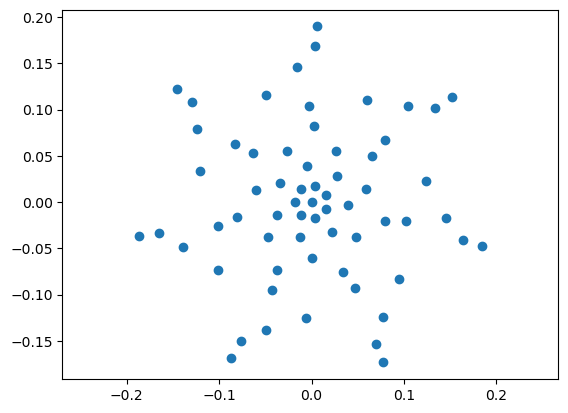

In [26]:
import matplotlib.pylab as plt

plt.plot( mg.mpos[0], mg.mpos[1], 'o' )
plt.axis( 'equal' );

This gives a nice impression of the microphone arrangement which consists of 7 inertwined planar logarithmic spirals (hard to see the spirals, I admit).

To map the sound, we need a mapping grid. Here we construct a simple regular and rectangular grid. Note that we have to decide about the size, spacing and the distance (z coordinate) from the array. Size and spacing define the number of points in the grid. The more points in the grid, the better the resolution of the acoustic photograph, but the longer the processing will take.

In [27]:
rg = acoular.RectGrid( x_min=-0.2, x_max=0.2,
                       y_min=-0.2, y_max=0.2,
                       z=0.3, increment=0.005 )
rg.nxsteps

81

The `rg` object now has all information about the grid.


## Beamforming

The actual method we will use is __beamforming__. Basically this works by using the combined microphones as a sound receiver with a directivity that is _steered_ to each one of the grid points in turn. One important element in beamforming and similar methods is the __steering vector__ implemented in Acoular in the `SteeringVector` class. This vector "connects" grid and microphones and takes into account the environmental conditions. These conditions are defined by the speed of sound and a possible background flow. If not set explicitely, a 'standard' environment is created in Acoular which assumes quiescent conditions (no flow) and a speed of sound of 343 m/s (air at 20°C).

In [28]:
st = acoular.SteeringVector( grid=rg, mics=mg )
st.env.c

343.0

Indeed the standard speed of sound is used.

Now, we define the method we want to use and set up a standard (basic) beamformer. For this need two ingredients: the CSM and the steering vector.

In [29]:
bb = acoular.BeamformerBase( freq_data=ps, steer=st )

Remember that Acoular uses lazy evaluation. No computation yet!

This means although we set up everything needed to perform beamforming, computation is postponed until the results are actually needed.

This will happen if we ask for the result. In this example we are interested in the sum for of all FFT frequency lines in the 3rd octave band 8000 Hz. This means we need the maps for all these frequencies and then add them together to synthetically "mimic" the result of a third octave filter for that band. The result is given as mean square sound pressure contribution at the center location of the microphone array. In Acoustics, we are usually like to have the results in the form of sound pressure levels (SPL). Acoular has a helper function `L_p` to compute the levels from the mean square.

In [64]:
pm = bb.synthetic( 8000, 3 )
Lm = acoular.L_p( pm )

The map is now stored in the array variable pm and the array Lm holds the soundpressure levels computed from this.

In [65]:
print(Lm.shape)

(81, 81)


The map has the same dimensions (41 x 41) as the grid. Any zero result in the map will be clipped to -350 dB level instead of -infinity.

Now lets plot the map as a color-coded image with 15 dB dynamic range between both ends of the color scale.

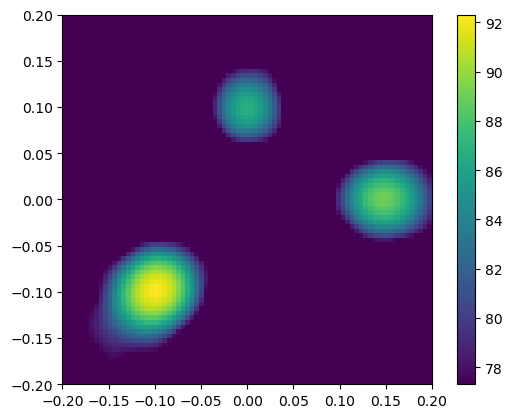

In [70]:

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

Now we enjoy the acoustic photograph of the three sources. Although it looks a bit blurry, we can guess the location of the sources and see as well that the sources have different strength.

## Beamforming under noisy conditions (diagonal removal technique)

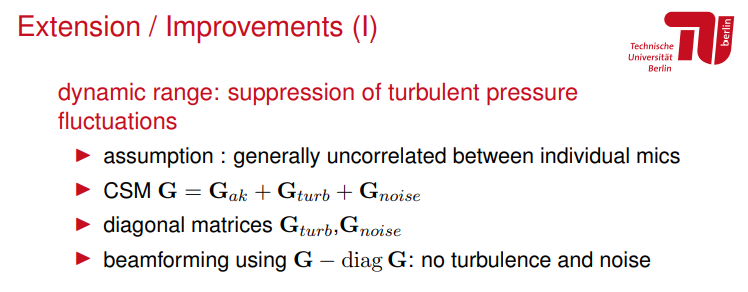


The previous result was computed using a variant of the beamformer that does apply the _diagonal removal technique_. This setting is the default and it means that we ignore the information in the main diagonal of the CSM, where the auto spectra (self-cross spectra) are stored. This is not too harmful in most cases and has the advantage that the map contains less artifacts. After this explanation, we of course now want to see the result with the full CSM including the diagonal (and hopefully with those artifacts). 

We achieve this by setting the corresponding flag of the `bb` object. Have a look at the documentation on [`BeamformerBase`](http://acoular.org/api_ref/generated/generated/acoular.fbeamform.BeamformerBase.html) to understand the `r_diag` flag.

In [ ]:
bb.r_diag = False

Obviously nothing happens (right away). This is due to the lazy evaluation again. To get the result we again have to explicitly ask for it and then we can again plot it. 


In [ ]:
Lm = acoular.L_p( bb.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

Nice! But indeed there are some artifacts that we may have mistaken for additional weak sound sources if we did not know that there are exactly three sound sources.


### More Noise!

To demonstrate the behaviour under very noisy conditions, we can use Acoular's [`SourceMixer`](https://www.acoular.org/api_ref/generated/generated/acoular.sources.SourceMixer.html#acoular.sources.SourceMixer) and add strong uncorrelated white noise to each of the microphone channels.

In [ ]:
wn = acoular.WNoiseGenerator(rms=15., seed=10, sample_freq=ts.sample_freq, numsamples=ts.numsamples)
noise_source = acoular.UncorrelatedNoiseSource(signal=wn, mics=mg)
source = acoular.SourceMixer(sources=[ts, noise_source])

As expected, nothing happens as long as we have not changed the source of the PowerSpectra object and recalculated the result. For now, we do the computation without the use of the diagonal removal technique.

In [ ]:
ps.source = source # PowerSpectra object that calculates the CSM
bb.r_diag = False # disable diagonal removal technique

Lm = acoular.L_p( bb.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

In [ ]:
bb.r_diag = True
Lm = acoular.L_p( bb.synthetic(8000,3) )

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

## Deconvolution


Instead of just beamforming we can apply a __deconvolution__ method. Deconvolution methods aim to remove all blur and artifacts from the result. The original blurry beamforming result can be understood as the _convolution_ of the ideal image with a filter kernel (the point spread function) which is specific to the beamforming algorithm. Deconvolution is any technique that attempts to reverse this convolution.

In Acoular the deconvolution is achieved in a similar way to beamforming. Instead of defining a `BeamformerBase` type of object, we have to use a "beamformer" with deconvolution. In our example we use the CleanSC deconvolution method and `BeamformerCleansc` type of object. Despite the python class name we chose it is not just a beamformer.

In [ ]:
%%time
acoular.config.global_caching = "overwrite" # in case we already collected the result in the cache

ts.name="three_sources.h5"
bs = acoular.BeamformerCleansc( freq_data=ps, steer=st )
Lm = acoular.L_p( bs.synthetic( 8000, 3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

Depending on the computer, this computation may take some seconds already. Now there is just one grid "point" per source and the image looks perfect.


# The caching mechanism

You may have noticed that whenever a results is computed, some messages about cache files appear. This happens because all computed results are cached to a file on disk. If one ask for the same result twice, it is still computed only once to save computing time and effort. This even means at the next start of this notebook no recalculation is necessary and all results are immediately available!

We can try out the automatic caching mechanism by setting up another `BeamformerCleansc` object `bs1` with all the same parameters as the `bs` object we did already use. 

In [ ]:
print(acoular.config.cache_dir)

In [ ]:
bs1 = acoular.BeamformerCleansc( freq_data=ps, steer=st )
print( bs, bs1 )

Note that while we have two identical objects, they are not the _same_ object. Thus, the `bs1` does not know about the results while `bs` still does. If we now trigger the computation of the results for `bs1` they are not actually computed, but just read from the cache. No noteable delay will happen when executing the following commands.

In [ ]:
%%time
acoular.config.global_caching = "individual"

Lm = acoular.L_p( bs1.synthetic(8000,3) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();

This is indeed the same result as before.

However, the cache is not used when parameters are changing. This is desirable because the result may also change. We demonstrate this here by changing one parameter of the `bs` object.

In [ ]:
print( bs.damp )
bs.damp = 0.99

With the new value, a new computation is necessary.


In [ ]:
%%time
Lm = acoular.L_p( bs.synthetic( 8000, 3 ) )
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend())
plt.colorbar();

This took again some time. In our simple example the result looks not much different, but there was no way to know this before.